In [1]:
# Import packages
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xml.etree import ElementTree as ET
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Data Profiling

In [ ]:
# Read and inspect data
df = pd.read_csv('stackexchange_data.csv')
df.columns = list(df.columns[1:])+['ToDrop']
df.drop('ToDrop',axis = 1, inplace = True)

print(df.shape)
display(df.info())
df.head()

In [ ]:
# Check for missing values
df.isna().sum()

## Data Processing

In [ ]:
# Create copy of dataframe
df2 = df.copy()

### Obtain only documents with Python Tag

In [ ]:
# Convert the obtained tags to a list
df2["Tags-2"] = df2["Tags"].str.split('|')
df2.head()

In [ ]:
# Filter the new dataframe to those only with python as a tag 
# Then create a column with one tag per row
keywords = ['python']
df_sub = df2[df2['Tags'].apply(lambda x: any([k in x for k in keywords]))]
df_sub = df_sub.explode("Tags-2")
df_sub.head()

In [ ]:
# Filter the DataFrame
print(df_sub.shape)
df_sub['Tags-2'].nunique()

## Dimensionality Reduction of Each Year

### Extract the Month and Year of the Data

In [ ]:
# Split the date and time portion of the Date column
df_sub[['Year_month', 'Time']] = df_sub["Date"].str.split("T", expand=True)

In [ ]:
# Obtain the year and month from the date
df_sub['yr'] = pd.to_datetime(df_sub['Year_month']).dt.year.astype(int)
df_sub['month'] = pd.to_datetime(df_sub['Year_month']).dt.to_period('M')
df_sub.head()

In [ ]:
# Filter the data to only contain the years 2010 to 2019
df_new = df_sub[(df_sub["yr"] >= 2010) & (df_sub["yr"] != 2020)]

In [ ]:
# Create a new coloumn that changes the delimeter of the tags to a space
df_new["Tags-3"] = df_new["Tags"].str.replace('|', " ")
df_new.head()

In [ ]:
#Save to csv
df_new.to_csv("processed_data.csv")

### Split Data by Year

In [ ]:
# Read the data - Start here when reopining the notebook
df_new = pd.read_csv("processed_data.csv")

In [ ]:
df_2010 = df_new[df_new["yr"] == 2010]
df_2011 = df_new[df_new["yr"] == 2011]
df_2012 = df_new[df_new["yr"] == 2012]
df_2013 = df_new[df_new["yr"] == 2013]
df_2014 = df_new[df_new["yr"] == 2014]
df_2015 = df_new[df_new["yr"] == 2015]
df_2016 = df_new[df_new["yr"] == 2016]
df_2017 = df_new[df_new["yr"] == 2017]
df_2018 = df_new[df_new["yr"] == 2018]
df_2019 = df_new[df_new["yr"] == 2019]
df_2020 = df_new[df_new["yr"] == 2020]

# Create a list of all dataframes
dfs = [df_2010, df_2011, df_2012, df_2013, df_2014,
       df_2015, df_2016, df_2017, df_2018, df_2019]

### Perform TF-IDF

- TFIDF was used to vectorize the tags obtained. 
- A TFIDF matrix was created for each year. 

In [ ]:
# Perform TFIDF for every year
vecs = ['vec_2010', 'vec_2011', 'vec_2012', 'vec_2013', 'vec_2014',
        'vec_2015', 'vec_2016', 'vec_2017', 'vec_2018', 'vec_2019']
df_tfidf = []
for i, data in enumerate(dfs):
    vecs[i] = TfidfVectorizer(min_df=500, token_pattern=r"(?u)\S\S+")
    df_tfidf.append(vecs[i].fit_transform(data["Tags-3"]))
    print(df_tfidf[i].shape)

In [ ]:
# Inspect the top terms obtained for 1 year from TFIDF
terms = vecs[0].get_feature_names()

# sum tfidf frequency of each term through documents
sums = df_tfidf[0].sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0,col]))

ranking = pd.DataFrame(data, columns=['term','rank'])
rank = ranking.sort_values('rank', ascending=False)
print(rank[:50])

### Identify Parameters for SVD
- SVD was tested using one year data to assess performance.
- Upon checking, it was observed that limitations on computational capacity allows us to run only a limited amount of model components which reaches approximately 50% of explained variance.  

In [ ]:
# Test run the SVD
svd_model = TruncatedSVD(n_components=100) # captures 50% of variance explained
svd_model.fit(df_tfidf[9])
model = svd_model.fit_transform(df_tfidf[9])
terms = vecs[9].get_feature_names()

pd.DataFrame(model)

In [ ]:
# Check the explained variance ratio obtained for one year
ve = svd_model.explained_variance_ratio_
ve

In [ ]:
# Check the cumulative explained variance ratio obtained for one year
ve.cumsum() >= 0.6

In [ ]:
# Plot the explained variance obtained
fig, ax = plt.subplots()
ax.plot(range(1, len(ve)+1), ve, 'o-', label='individual')
ax.plot(range(1, len(ve)+1), ve.cumsum(), 'o-', label='cumulative')
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained');

In [ ]:
# Check the best features for one SV
best_features = [(terms[i], svd_model.components_[0][i]) 
                 for i in svd_model.components_[0].argsort()[::-1]]
best_features[:10]

### Perform SVD from obtained optimal parameters

In [ ]:
# Obtain the SVD results for all years

df_all = pd.DataFrame()
for i, year in tqdm(enumerate(np.arange(2010, 2020))):
    if i == 0:
        svd_model = TruncatedSVD(n_components=50)
        svd_model.fit(df_tfidf[i])
        terms = vecs[i].get_feature_names()
    else:
        svd_model = TruncatedSVD(n_components=100)
        svd_model.fit(df_tfidf[i])
        terms = vecs[i].get_feature_names()
        
    df_tags = pd.DataFrame()
    d_all = {}
    for i, comp in enumerate(svd_model.components_):   
        if i != 11:
            best_features = [(terms[n], np.abs(svd_model.components_[i][n]))
                 for n in np.abs(svd_model.components_[i].argsort())[::-1]]  
            d_ = {}
            d_["SV_"+str(i)] = best_features  
            d_all.update(d_)
        else:
            break
    df_tags = df_tags.from_dict(d_all)
    df_tags['year'] = year
    df_all = df_all.append(df_tags)
    display(df_all)

In [ ]:
# Save the results to csv
df_all.to_csv("svd_results_wordlist.csv")

# Clustering of 2019 SVs

In [ ]:
df_new = pd.read_csv("processed_data.csv")
data = df_new[df_new["yr"] == 2019]
vectorizer = TfidfVectorizer(min_df=500, token_pattern=r"(?u)\S\S+")
df_tfidf = vectorizer.fit_transform(data["Tags-3"])
feature_names = vectorizer.get_feature_names()
print(df_tfidf.shape)

## Identify Minimum Number of N_Components for at least 60% of Variance

In [ ]:
svd = TruncatedSVD(n_components=100,
                  random_state = 1337)
svd.fit(df_tfidf)
s = svd.explained_variance_ratio_
min_c = len(s[s.cumsum() < 0.6]) + 1
print(f"60% of variance can be explained by n_components = {min_c}")

## Performing SVD on 2019 Tags

In [ ]:
svd_model = TruncatedSVD(n_components=min_c)
svd_model.fit(df_tfidf)
df_svd = svd_model.transform(df_tfidf)
df_svd.shape

### Feature Importances in Each SV

In [ ]:
df_tags = pd.DataFrame()
d_all = {}
for i, comp in enumerate(svd_model.components_):   
    best_features = [(feature_names[n], np.abs(svd_model.components_[i][n]))
                 for n in np.abs(svd_model.components_[i].argsort())[::-1]] 
    d_ = {}
    d_["SV_"+str(i)] = best_features  
    d_all.update(d_)

df_tags = df_tags.from_dict(d_all)
df_tags

In [ ]:
# with open('svd_model.pkl', 'wb') as file_svd:
#     svd_dct = {}
#     svd_dct['model'] = svd_model
#     svd_dct['df'] = df_svd
#     svd_dct['tags'] = df_tags
#     pickle.dump(svd_dct, file_svd)

## Clustering Dimensionality Reduced Dataset
https://www.dummies.com/programming/big-data/data-science/data-science-performing-hierarchical-clustering-with-python/

In [3]:
with open('svd_model.pkl', 'rb') as file_svd:
    svd_dct = pickle.load(file_svd)
    svd_model = svd_dct['model']
    df_svd = svd_dct['df']
    df_tags = svd_dct['tags']

### Clustering 1

In [4]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=200,
                    verbose = 1,
                    random_state=1337)
print('Starting Fit...')
clustering.fit(df_svd)
Kx = clustering.cluster_centers_
Kx_mapping = {case:cluster for case,
 cluster in enumerate(clustering.labels_)}

Starting Fit...
Initialization complete
Iteration 0, inertia 67886.96899800438
Iteration 1, inertia 55952.584986994014
Iteration 2, inertia 55443.12680935263
Iteration 3, inertia 55305.51093943072
Iteration 4, inertia 55269.62350002452
Iteration 5, inertia 55253.56046721704
Iteration 6, inertia 55238.87524874981
Iteration 7, inertia 55177.07866368456
Iteration 8, inertia 55100.973614000155
Iteration 9, inertia 55046.386202673384
Iteration 10, inertia 55040.473231075994
Iteration 11, inertia 55031.91373628383
Iteration 12, inertia 54983.502684892635
Iteration 13, inertia 54941.653006091045
Iteration 14, inertia 54912.92143654309
Iteration 15, inertia 54912.83309138173
Iteration 16, inertia 54912.8101311745
Iteration 17, inertia 54912.7992732219
Iteration 18, inertia 54912.78455107094
Iteration 19, inertia 54912.779539031464
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 68248.99398896206
Iteration 1, inertia 56513.363344809164
Iteration 2, in

In [5]:
# with open('kmeans_clustering.pkl', 'wb') as file_kx:
#     kx_dct = {}
#     kx_dct['centers'] = Kx
#     kx_dct['mapping'] = Kx_mapping
#     pickle.dump(kx_dct, file_kx)

### Clustering 2

In [2]:
with open('kmeans_clustering.pkl', 'rb') as file_kx:
    kx_dct = pickle.load(file_kx)
    Kx = kx_dct['centers']
    Kx_mapping = kx_dct['mapping']

In [63]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(Kx, method='ward', optimal_ordering=True)

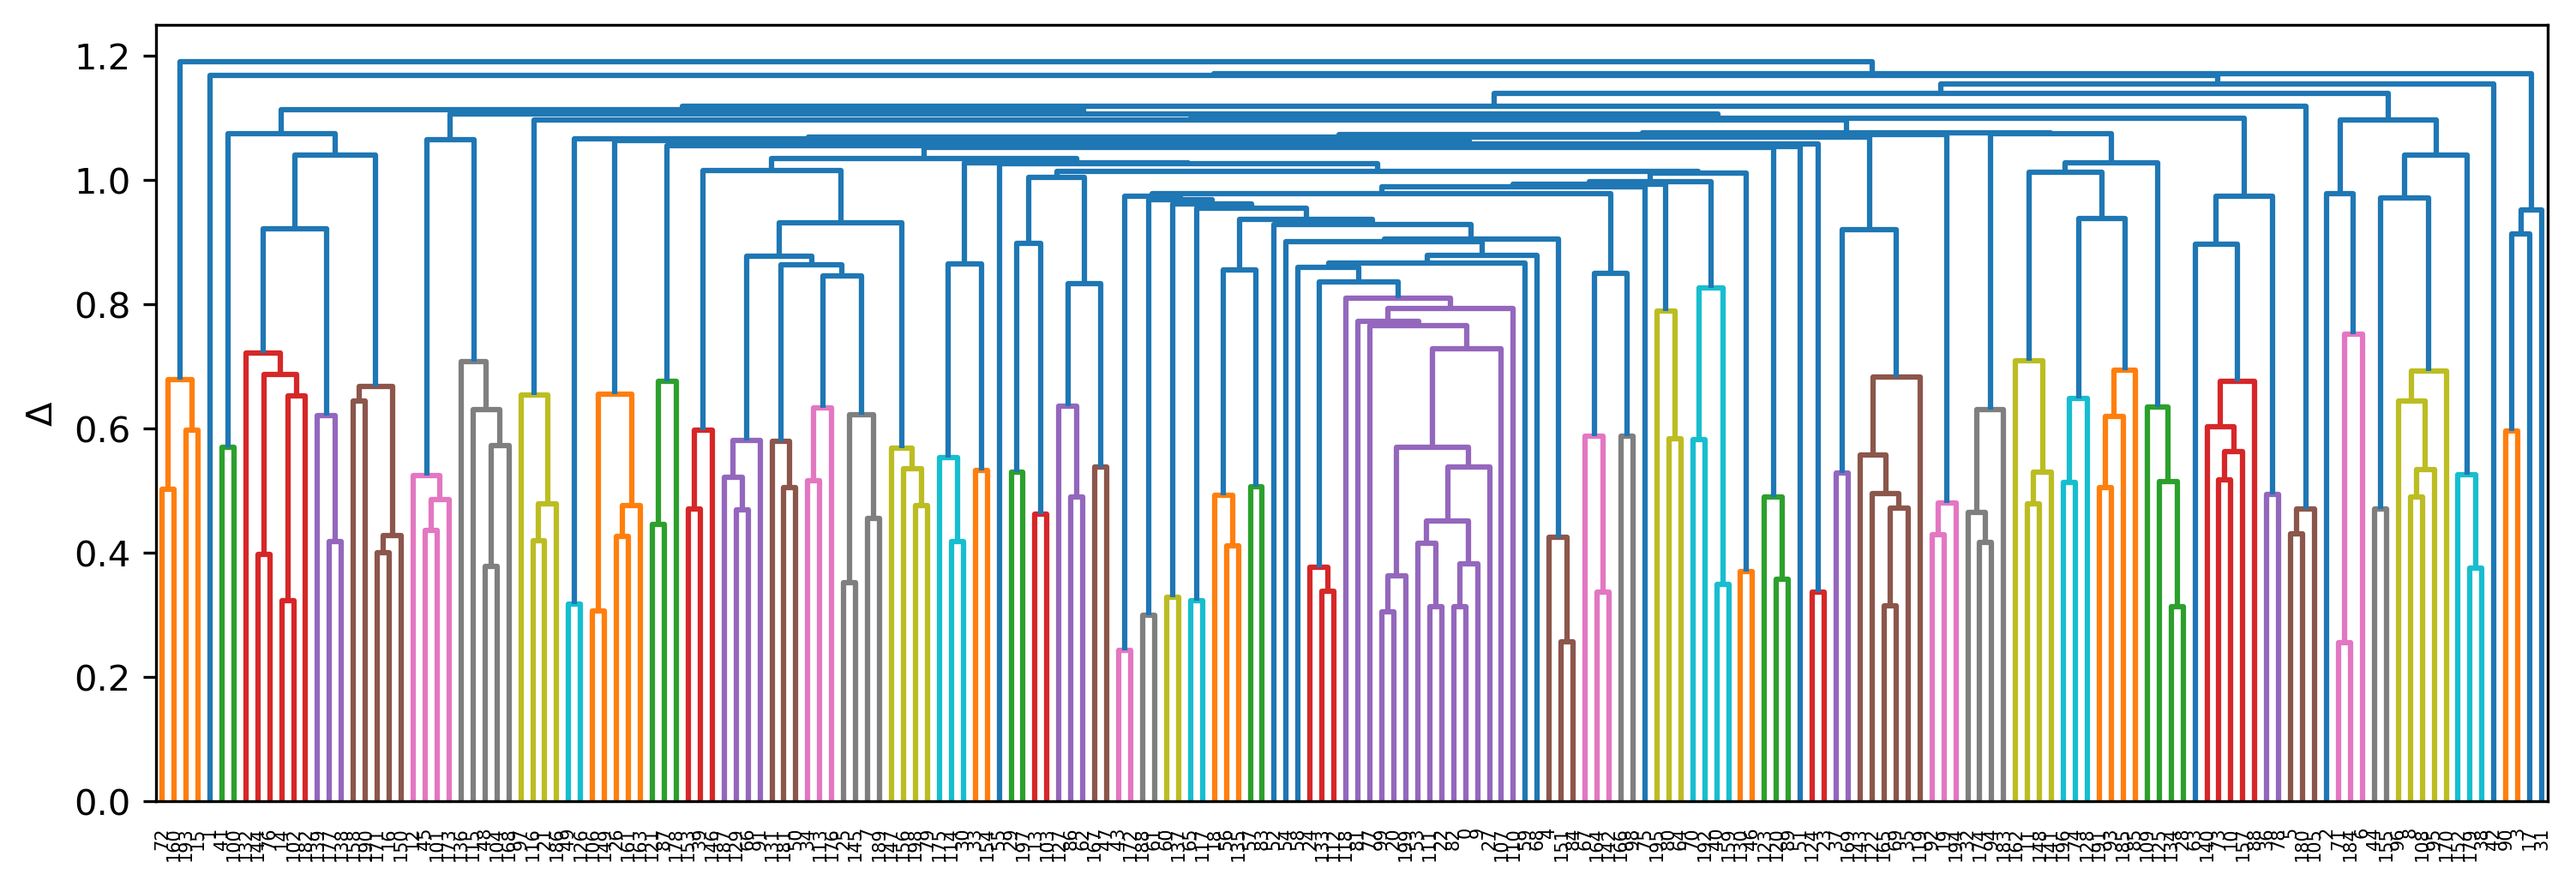

In [64]:
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$\Delta$');
plt.axhline(y=2.4, c='r')
plt.show()

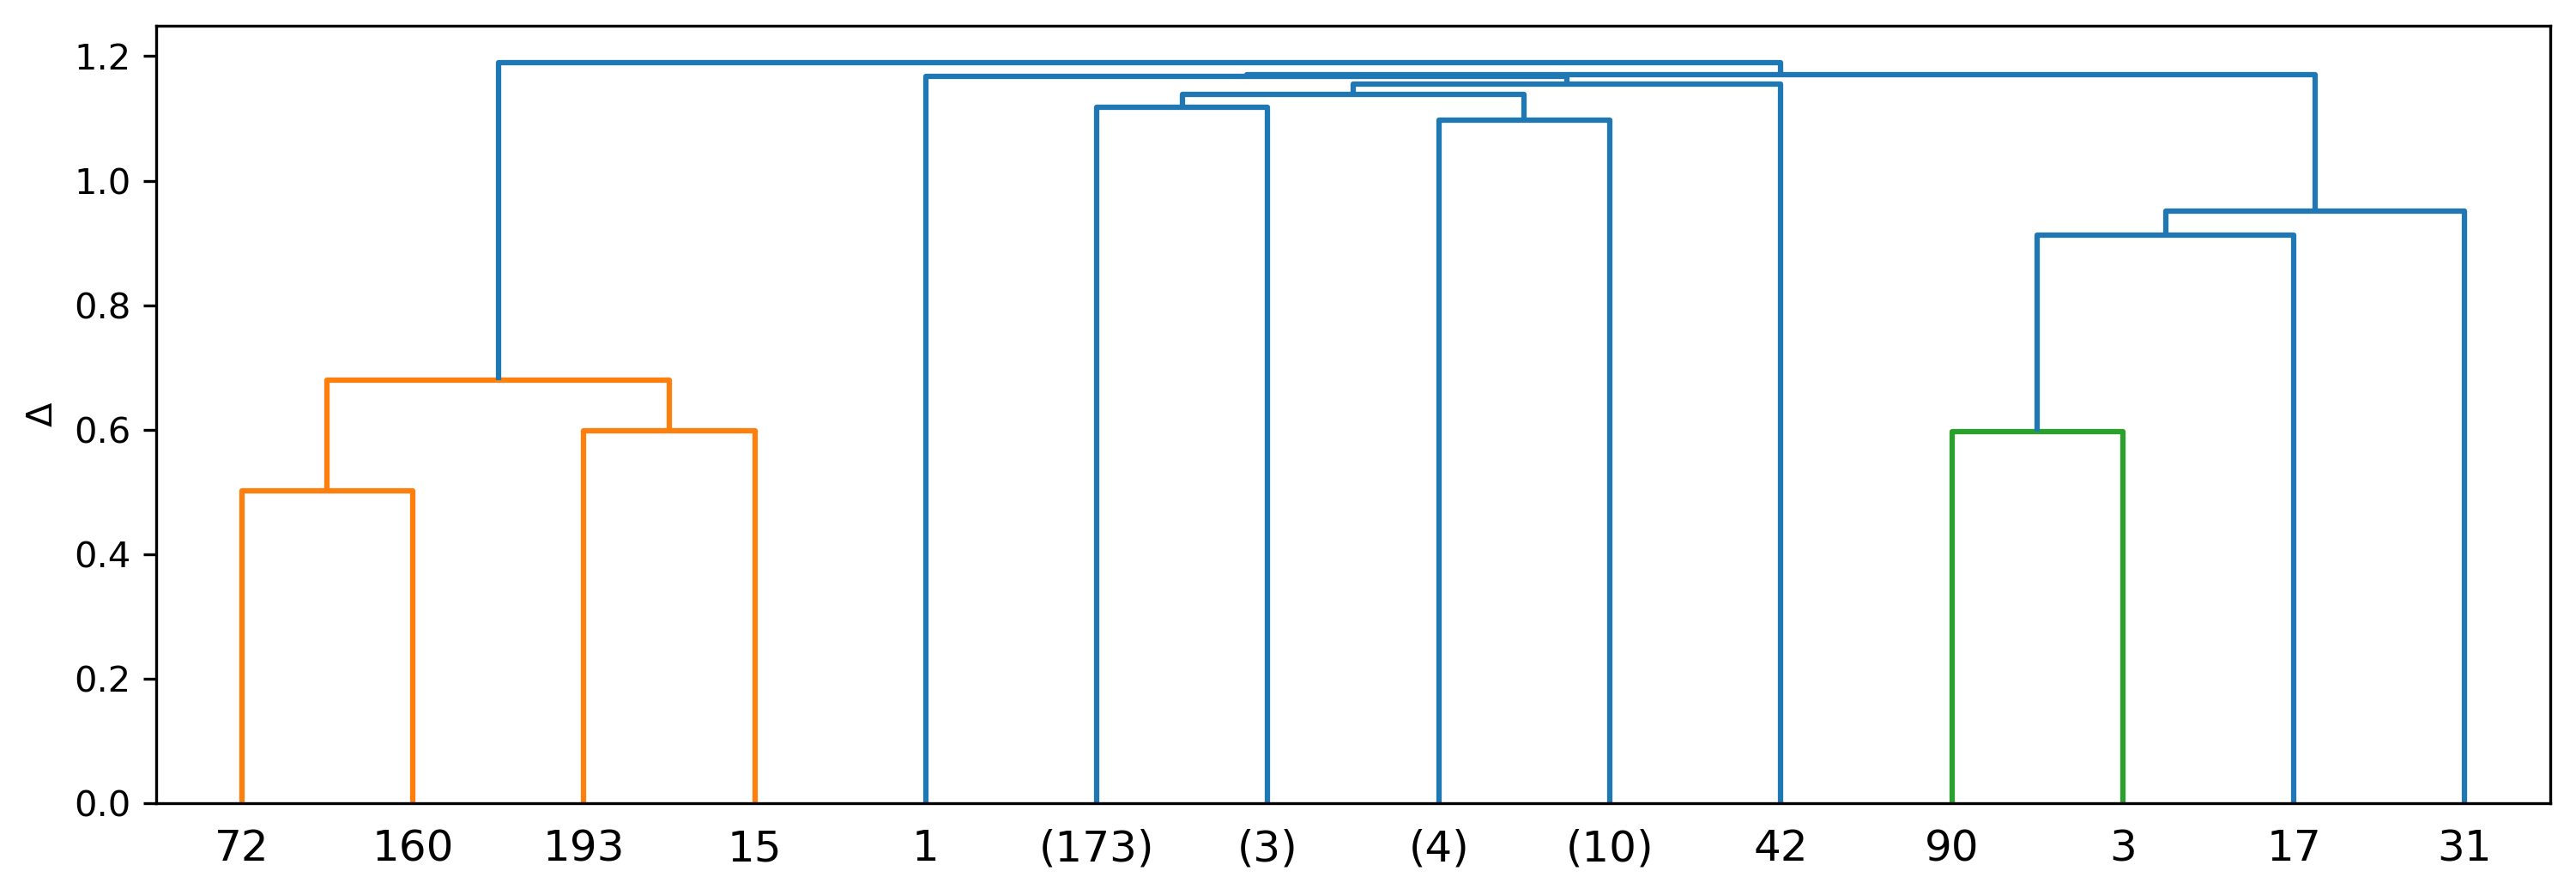

In [65]:
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dendo = dendrogram(Z, truncate_mode='level',p=5)
plt.ylabel(r'$\Delta$')
plt.axhline(y=2.55, c='r')
plt.show()

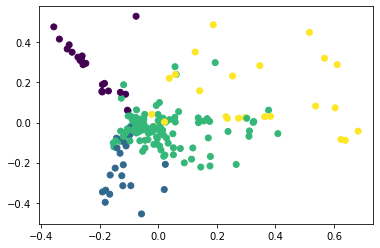

In [54]:
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA

y_predict = fcluster(Z, t=2.5, criterion='distance')
X_res_new = PCA(n_components=2, random_state=1337).fit_transform(Kx)
plt.scatter(X_res_new[:,0], X_res_new[:,1], c=y_predict)

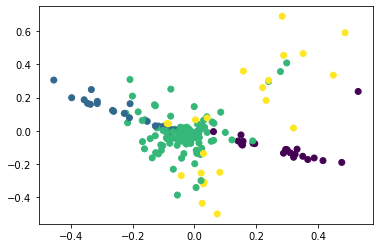

In [32]:
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA

y_predict = fcluster(Z, t=2.5, criterion='distance')
X_res_new = PCA(n_components=3, random_state=1337).fit_transform(Kx)
plt.scatter(X_res_new[:,1], X_res_new[:,2], c=y_predict)

In [33]:
from scipy.cluster.hierarchy import fcluster
labels = fcluster(Z, t=2.5, criterion='distance')

H_mapping = {case:cluster for case,
 cluster in enumerate(labels)}
final_mapping = {case:H_mapping[Kx_mapping[case]]
 for case in Kx_mapping}

In [34]:
len(final_mapping)

815848

In [35]:
df_new = pd.read_csv("processed_data.csv")
df_ = df_new[df_new.yr == 2019]

In [36]:
df_['Cluster'] = list(final_mapping.values())
df_.head()

<ipython-input-36-a42fc020d3a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['Cluster'] = list(final_mapping.values())


,Unnamed: 0,Unnamed: 0.1,XML_Line,Date,Title,Tags,Tags-2,Year_month,Time,yr,month,Tags-3,Cluster
3301546,2456513,0,42668723,2019-01-01T00:02:37.510,Unable to print a class list attribute using i...,python|python-3.x|list|class|printing,python,2019-01-01,00:02:37.510,2019,2019-01,python python-3.x list class printing,3
3301547,2456513,0,42668723,2019-01-01T00:02:37.510,Unable to print a class list attribute using i...,python|python-3.x|list|class|printing,python-3.x,2019-01-01,00:02:37.510,2019,2019-01,python python-3.x list class printing,3
3301548,2456513,0,42668723,2019-01-01T00:02:37.510,Unable to print a class list attribute using i...,python|python-3.x|list|class|printing,list,2019-01-01,00:02:37.510,2019,2019-01,python python-3.x list class printing,3
3301549,2456513,0,42668723,2019-01-01T00:02:37.510,Unable to print a class list attribute using i...,python|python-3.x|list|class|printing,class,2019-01-01,00:02:37.510,2019,2019-01,python python-3.x list class printing,3
3301550,2456513,0,42668723,2019-01-01T00:02:37.510,Unable to print a class list attribute using i...,python|python-3.x|list|class|printing,printing,2019-01-01,00:02:37.510,2019,2019-01,python python-3.x list class printing,3


In [37]:
df_[df_.Cluster == 1]['Tags-2'].value_counts()

python                 14620
tensorflow              8921
keras                   6056
machine-learning        3027
deep-learning           2239
                       ...  
bgr                        1
memory-mapped-files        1
hardware                   1
4d                         1
centos7                    1
Name: Tags-2, Length: 1539, dtype: int64

In [58]:
df_.to_csv('clustered_data.csv')